In [54]:
import numpy as np
from scipy.signal import spectrogram
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


import numpy as np

#detect available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [55]:
batch_size = 512
n_steps = 200
features = 64

# # Load tiny training dataset
tiny_train_dataset = tf.data.experimental.load(
    'tiny_train_dataset',
    element_spec=(
        tf.TensorSpec(shape=(batch_size, n_steps, features), dtype=tf.float64),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.int64)
    )
)

# Load tiny testing dataset
tiny_test_dataset = tf.data.experimental.load(
    'tiny_test_dataset',
    element_spec=(
        tf.TensorSpec(shape=(batch_size, n_steps, features), dtype=tf.float64),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.int64)
    )
)

# Print shapes
for X, y in tiny_train_dataset.take(1):
    print("Tiny Training Dataset - X shape:", X.shape)
    print("Tiny Training Dataset - y shape:", y.shape)

for X, y in tiny_test_dataset.take(1):
    print("Tiny Testing Dataset - X shape:", X.shape)
    print("Tiny Testing Dataset - y shape:", y.shape)




Tiny Training Dataset - X shape: (512, 200, 64)
Tiny Training Dataset - y shape: (512,)
Tiny Testing Dataset - X shape: (512, 200, 64)
Tiny Testing Dataset - y shape: (512,)


In [56]:
print(len(tiny_train_dataset))
print(len(tiny_test_dataset))

19
5


In [57]:

from models import *

models = [recurrent,recurrent_2,wavenet,convolutional,convolutional_2] 
names = ['recurrent','recurrent_complex','wavenet','convolutional','convolutional_regularized']
trained_models = []
results = {}
for model,name in zip(models,names):
    model = model(features,n_steps)
    epochs = 30
    result = model.fit(tiny_train_dataset, epochs=epochs, validation_data=tiny_test_dataset)
    results[name] = result
    trained_models.append(model)



Epoch 1/30
19/19 [==============================] - 4s 140ms/step - loss: 1.0711 - accuracy: 0.4897 - val_loss: 1.1644 - val_accuracy: 0.2891
Epoch 2/30
19/19 [==============================] - 3s 133ms/step - loss: 1.0432 - accuracy: 0.4962 - val_loss: 1.1754 - val_accuracy: 0.2891
Epoch 3/30
19/19 [==============================] - 3s 134ms/step - loss: 1.0425 - accuracy: 0.4962 - val_loss: 1.1799 - val_accuracy: 0.2891
Epoch 4/30
19/19 [==============================] - 3s 134ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1806 - val_accuracy: 0.2891
Epoch 5/30
19/19 [==============================] - 3s 133ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1807 - val_accuracy: 0.2891
Epoch 6/30
19/19 [==============================] - 3s 135ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1810 - val_accuracy: 0.2891
Epoch 7/30
19/19 [==============================] - 3s 134ms/step - loss: 1.0423 - accuracy: 0.4962 - val_loss: 1.1814 - val_accuracy: 0.2891
Epoch 

In [58]:
print(len(results))

5


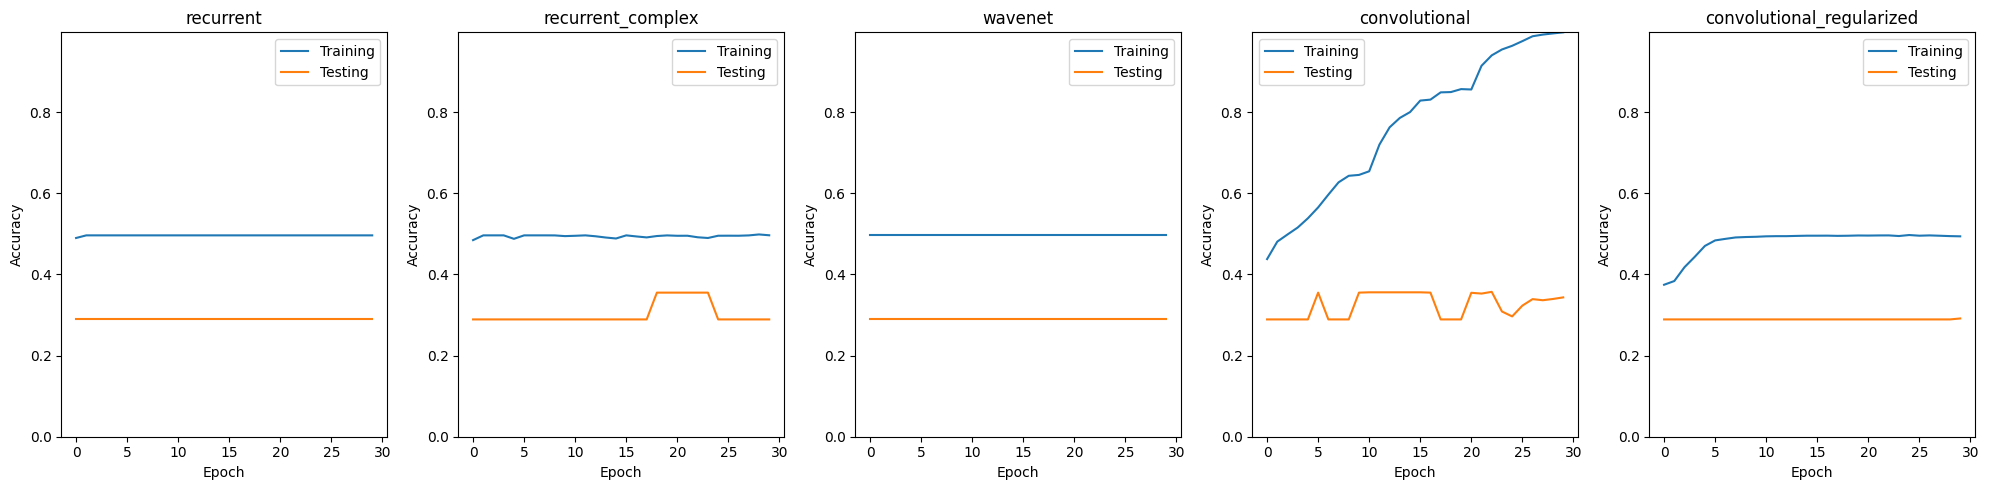

In [59]:
import matplotlib.pyplot as plt

 

num_models = len(results)
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 5))  

max_accuracy = 0

for i, (model_name, result) in enumerate(results.items()):
    ax = axes[i]
    ax.plot(result.history['accuracy'], label='Training')
    ax.plot(result.history['val_accuracy'], label='Testing')
    ax.set_title(model_name)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend()

   
    max_accuracy = max(max_accuracy, max(result.history['accuracy']))

 
for ax in axes:
    ax.set_ylim([0, max_accuracy])

plt.tight_layout()
plt.savefig("model_comparison.png")


5/5 [==============================] - 1s 109ms/step


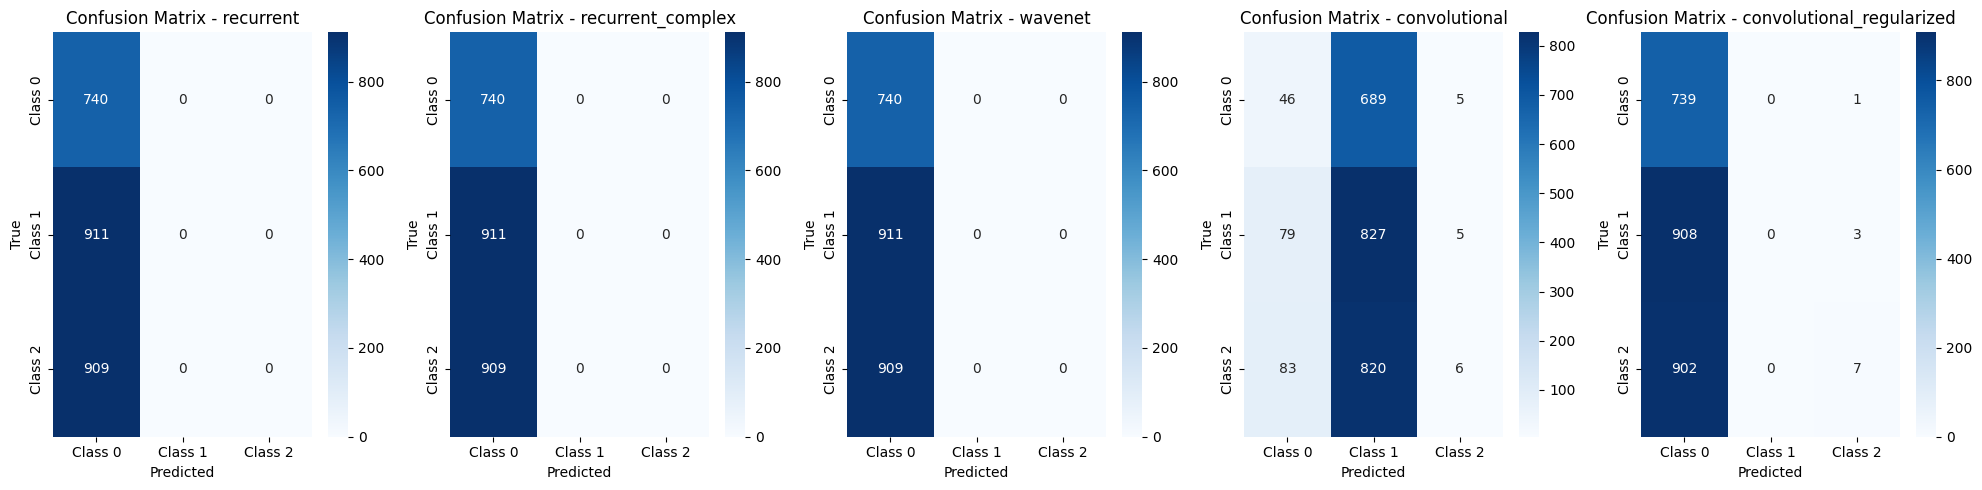

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


num_models = len(trained_models)
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 5))

for i, (name, model) in enumerate(zip(results.keys(), trained_models)):
 
    y_pred_probs = model.predict(tiny_test_dataset.map(lambda x, y: x))
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

    # Extract true labels from the dataset
    true_labels = np.concatenate([y.numpy() for _, y in tiny_test_dataset])

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, y_pred)

    # Plot the confusion matrix
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
                yticklabels=['Class 0', 'Class 1', 'Class 2'], ax=ax)
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.savefig("confusion_matrix_comparison.png")
plt.show()
